In [26]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
import fire
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler

from data_generator_breast import BreastPathQDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency
from utils import nll_criterion_laplacian

matplotlib.rcParams['font.size'] = 8

In [27]:
base_model = 'efficientnetb0'

In [28]:
assert base_model in ['resnet50', 'resnet101', 'densenet121', 'densenet201', 'efficientnetb0', 'efficientnetb4']
device = torch.device("cuda:1")
resize_to = (384, 384)

In [29]:
batch_size = 16

data_set = BreastPathQDataset(data_dir='/media/fastdata/laves/breastpathq/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./breastpathq_valid_indices.pth')
test_indices = torch.load('./breastpathq_test_indices.pth')
#calib_indices = test_indices[:len(test_indices)//2]
#test_indices = test_indices[len(test_indices)//2:]

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([600])
torch.Size([1200])


In [30]:
from glob import glob
model = BreastPathQModel(base_model, out_channels=1).to(device)

checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_laplacian_breastpathq_4*.pth.tar")[0]

# densenet121:
# checkpoint_path = f"/media/fastdata/laves/regression_snapshots/{base_model}_laplacian_breastpathq_best.pth.tar"

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)

Loading previous weights at epoch 487 from
/media/fastdata/laves/regression_snapshots/efficientnetb0_laplacian_breastpathq_487.pth.tar


In [31]:
model.eval()
mus_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_calib.append(mu.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

mu_calib = torch.cat(mus_calib, dim=0).clamp(0, 1)
var_calib = torch.cat(vars_calib, dim=0)
logvar_calib = torch.cat(logvars_calib, dim=0)
target_calib = torch.cat(targets_calib, dim=0)

print("l1 =", torch.nn.functional.l1_loss(mu_calib, target_calib).item())

100%|██████████| 38/38 [00:59<00:00,  1.39s/it]

l1 = 0.04927708953619003


In [32]:
err_calib = torch.pow(target_calib-mu_calib, 2).sqrt()

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp()
uncert_calib_epistemic = var_calib.sqrt()

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).clamp(0, 1)  # total

<IPython.core.display.Javascript object>


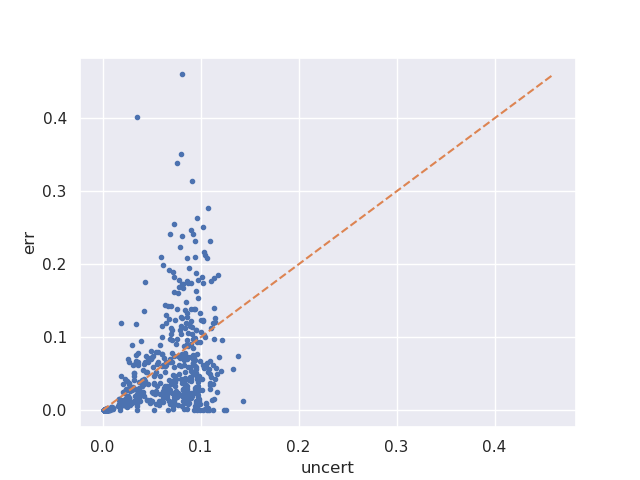

In [33]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [34]:
# calculate optimal T
S = err_calib.sum() / uncert_calib.sum()
print(S)

tensor(0.9195, device='cuda:1')


In [35]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))
        
    def forward(self, x):
        return self.S.mul(x)

In [36]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-4, max_iter=100)

def closure():
    s_opt.zero_grad()
    
    loss = nll_criterion_laplacian(mu_calib, scaler(uncert_calib).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

0.9126335382461548


In [37]:
print(nll_criterion_laplacian(mu_calib, uncert_calib.log(), target_calib).item())
print(nll_criterion_laplacian(mu_calib, (S*uncert_calib).log(), target_calib).item())
print(nll_criterion_laplacian(mu_calib, scaler(uncert_calib).log(), target_calib).item())

-2.805358648300171
-2.822472095489502
-2.8237247467041016


In [38]:
print(torch.nn.functional.l1_loss(uncert_calib, err_calib, reduction='sum').item())
print(torch.nn.functional.l1_loss((S*uncert_calib), err_calib, reduction='sum').item())
print(torch.nn.functional.l1_loss(scaler(uncert_calib), err_calib, reduction='sum').item())

21.189224243164062
20.523571014404297
20.478042602539062


In [39]:
outlier = 0.025
n_bins = 51

<IPython.core.display.Javascript object>


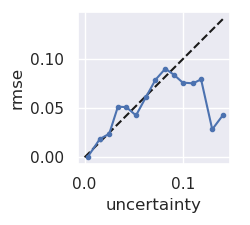

0.009794028475880623


In [40]:
uce, err_in_bin, avg_sigma_in_bin, prop_in_bin = uceloss(err_calib, uncert_calib)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())
plt.show()

<IPython.core.display.Javascript object>


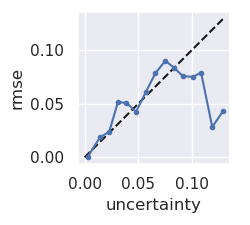

0.00905554462224245


In [41]:
uce, err_in_bin, avg_sigma_in_bin, num_in_bin = uceloss(err_calib, (S*uncert_calib))
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item())
plt.show()

<IPython.core.display.Javascript object>


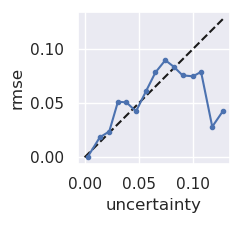

0.009155310690402985


<IPython.core.display.Javascript object>


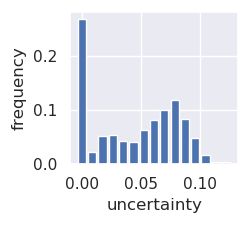

In [42]:
uce, err_in_bin, avg_uncert_in_bin, in_bin = uceloss(err_calib, scaler(uncert_calib))
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item())
fig, ax = plot_frequency(scaler(uncert_calib).cpu(), in_bin.cpu())
fig.show()

In [43]:
mus_test = []
vars_test = []
logvars_test = []
targets_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_test.append(mu.detach())
        vars_test.append(var_bayesian.detach())
        logvars_test.append(logvar.detach())
        targets_test.append(target.detach())

mu_test = torch.cat(mus_test, dim=0).clamp(0, 1)
var_test = torch.cat(vars_test, dim=0)
logvar_test = torch.cat(logvars_test, dim=0)
target_test = torch.cat(targets_test, dim=0)

print("l1 =", torch.nn.functional.l1_loss(mu_test, target_test).item())

100%|██████████| 75/75 [02:01<00:00,  1.63s/it]

l1 = 0.049726225435733795


In [44]:
err_test = torch.pow(target_test-mu_test, 2).sqrt()

uncert_aleatoric_test = logvar_test.exp()
uncert_epistemic_test = var_test.sqrt()

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.clamp(0, 1)
else:
    uncert_test = (uncert_aleatoric_test + uncert_epistemic_test).clamp(0, 1)  # total

In [45]:
print(nll_criterion_laplacian(mu_test, uncert_test.log(), target_test).item())
print(nll_criterion_laplacian(mu_test, S*uncert_test.log(), target_test).item())
print(nll_criterion_laplacian(mu_test, scaler(uncert_test).log(), target_test).item())

-2.748749256134033
-2.6247873306274414
-2.7675089836120605


In [46]:
print(torch.nn.functional.l1_loss(uncert_test, err_test, reduction='sum').item())
print(torch.nn.functional.l1_loss((S*uncert_test), err_test, reduction='sum').item())
print(torch.nn.functional.l1_loss((scaler.S*uncert_test), err_test, reduction='sum').item())

42.063297271728516
40.69565200805664
40.60155487060547


In [47]:
outlier = 0.0
n_bins = 21

<IPython.core.display.Javascript object>


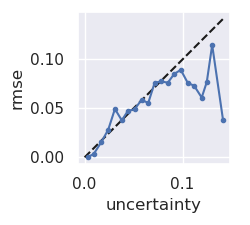

tensor([0.0079], device='cuda:1')


In [48]:
uce, err_in_bin, avg_sigma_in_bin, _ = uceloss(err_test, uncert_test, outlier=outlier, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce)

<IPython.core.display.Javascript object>


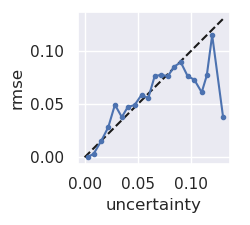

tensor([0.0065], device='cuda:1')


In [49]:
uce, err_in_bin, avg_sigma_in_bin, _ = uceloss(err_test, S*uncert_test,  outlier=outlier, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce)

<IPython.core.display.Javascript object>


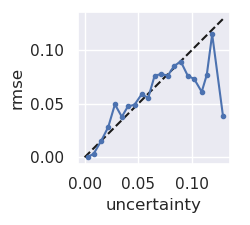

tensor([0.0064], device='cuda:1', grad_fn=<AddBackward0>)


<IPython.core.display.Javascript object>


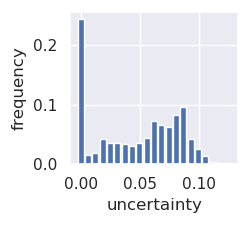

In [50]:
uce, err_in_bin, uncert_in_bin, in_bin = uceloss(err_test, scaler(uncert_test), outlier=outlier, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), uncert_in_bin.cpu())
plt.show()
print(uce)
fig, ax = plot_frequency(scaler(uncert_test).cpu(), in_bin.cpu(), n_bins=n_bins)
fig.show()